In [2]:
import math 
import pandas_datareader as web 
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential 
from keras.layers import Dense, LSTM 
import matplotlib.pyplot as plt 

In [3]:
d  =  pd.read_excel(r"C:\Users\ansh\Desktop\Nifty 50 Historical Data.xlsx")

In [6]:
d.shape

(6899, 7)

In [57]:
nifty = d.sort_values(by = 'Date')
nifty

,Date,Price,Open,High,Low,Volume,Chg%
6898,1995-11-06,988.92,1001.53,1001.53,988.92,0,-0.0111
6897,1995-11-07,978.22,987.17,987.17,977.05,0,-0.0108
6896,1995-11-08,964.01,976.28,976.28,962.98,0,-0.0145
6895,1995-11-09,953.07,960.32,960.32,952.13,0,-0.0113
6894,1995-11-10,948.82,951.93,951.93,946.00,0,-0.0045
...,...,...,...,...,...,...,...
4,2023-07-21,19745.00,19800.45,19887.40,19700.00,312.46B,-0.0117
3,2023-07-24,19672.35,19748.45,19782.75,19658.30,265.56B,-0.0037
2,2023-07-25,19680.60,19729.35,19729.35,19615.95,369.65B,0.0004
1,2023-07-26,19778.30,19733.35,19825.60,19716.70,244.75B,0.0050


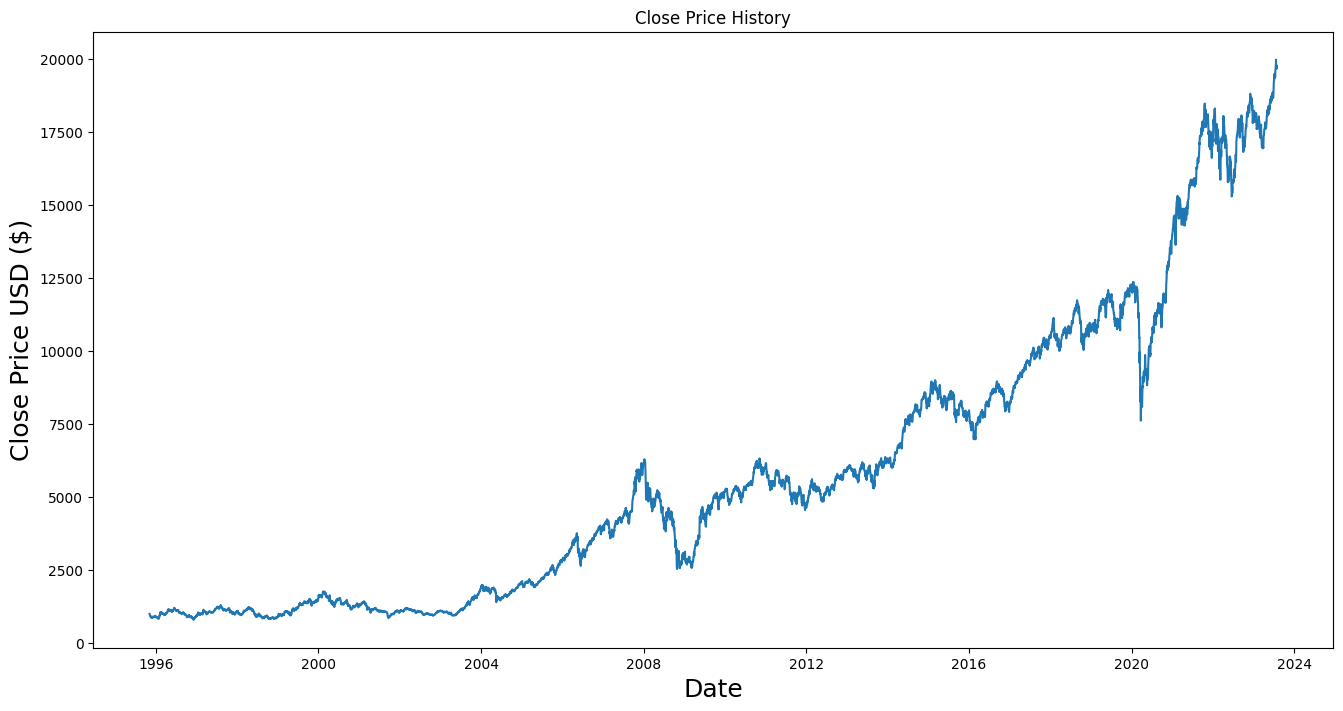

In [58]:
plt.figure(figsize=(16,8))
plt.title('Close Price History') 
plt.plot(nifty['Date'], nifty['Price']) 
plt.xlabel('Date',fontsize=18) 
plt.ylabel('Close Price USD ($)',fontsize=18) 
plt.show() 

In [9]:
#Create a new dataframe with only the 'Close' column 
data = nifty.filter(['Price']) 

In [62]:
#Converting the dataframe to a numpy array 
dataset = data.values 
#Get /Compute the number of rows to train the model on 
training_data_len = math.ceil( len(dataset) *0.80) 

In [63]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset) 

In [64]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ] 
#Split the data into x_train and y_train data sets 
x_train=[] 
y_train = [] 
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0]) 
    y_train.append(train_data[i,0]) 


In [65]:
#Convert x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train) 

In [66]:
#Reshape the data into the shape accepted by the LSTM 
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 

In [67]:
#Build the LSTM network model 
model = Sequential() 
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1))) 
model.add(LSTM(units=50, return_sequences=False)) 
model.add(Dense(units=25)) 
model.add(Dense(units=1)) 

In [68]:
#Compile the model 
model.compile(optimizer='adam', loss='mean_squared_error') 

In [69]:
#Train the model 
model.fit(x_train, y_train, batch_size=1, epochs=1) 

5460/5460 [==============================] - 80s 14ms/step - loss: 1.8548e-04


In [70]:
#Test data set 
test_data = scaled_data[training_data_len - 60: , : ] 
#Create the x_test and y_test data sets 
x_test = [] 
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0]) 

In [71]:
#Convert x_test to a numpy array 
x_test = np.array(x_test) 


In [72]:
#Reshape the data into the shape accepted by the LSTM 
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) 

In [73]:
#Getting the models predicted price values 
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling 

44/44 [==============================] - 1s 9ms/step


In [74]:
#Calculate/Get the value of RMSE 
rmse=np.sqrt(np.mean(((predictions- y_test)**2))) 
rmse

442.2793923895473

In [75]:
#Plot/Create the data for the graph 
train = data[:training_data_len].copy() 
valid = data[training_data_len:].copy()
valid['Predictions'] = predictions.copy() 

In [76]:
train.shape

(5520, 1)

In [77]:
valid.shape

(1379, 2)

In [78]:
nifty.shape

(6899, 7)

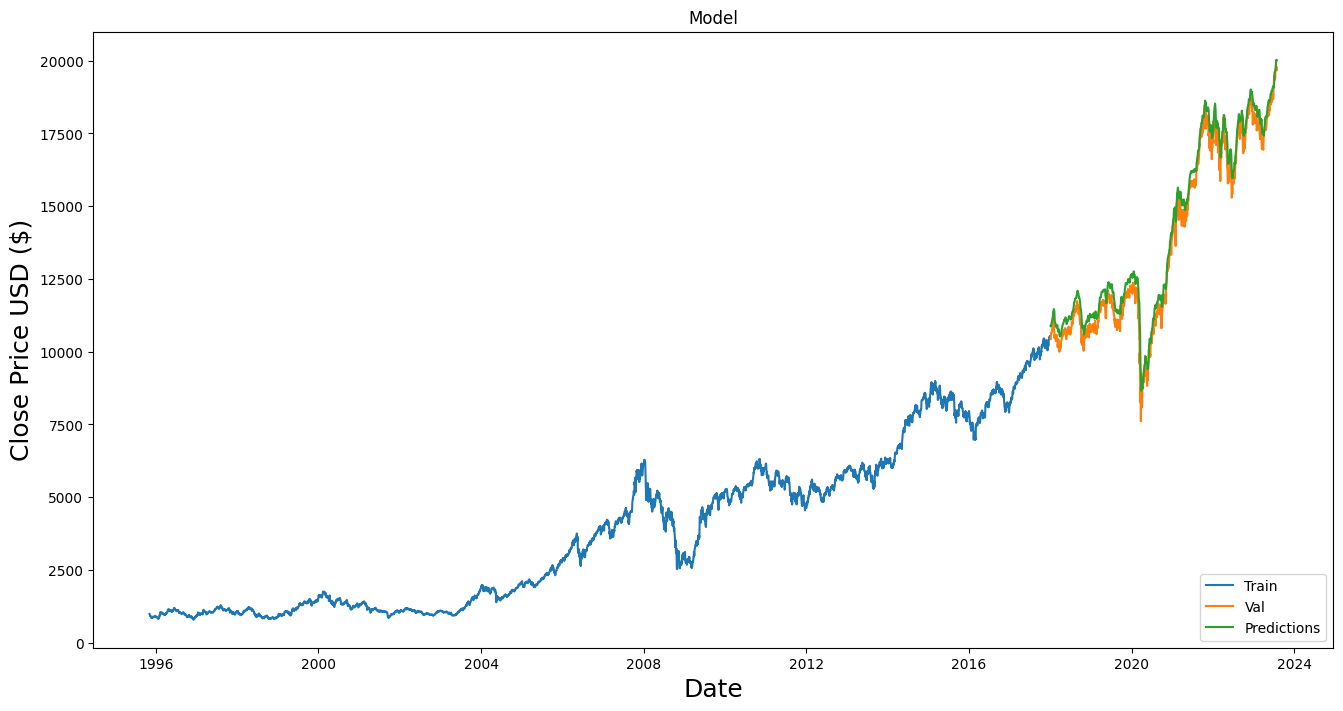

In [87]:
#Visualize the data 
plt.figure(figsize=(16,8)) 
plt.title('Model') 
plt.xlabel('Date', fontsize=18) 
plt.ylabel('Close Price USD ($)', fontsize=18) 
plt.plot(nifty['Date'][:len(train['Price'])], train['Price']) 
plt.plot(nifty['Date'][-len(valid['Price']):], valid[['Price', 'Predictions']]) 
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right') 
plt.show()